# **CHALLENGE: TELECOM X - PARTE 2**

## Descripción del Proyecto

Desarrollar modelos predictivos capaces de determinara los clientes con mayor probabilidad de cancelar sus servicios.


### 🧠 Objetivos del Desafío:


- Preparar los datos para el modelado (tratamiento, codificación, normalización).

- Realizar análisis de correlación y selección de variables.

- Entrenar dos o más modelos de clasificación.

- Evaluar el rendimiento de los modelos con métricas.

- Interpretar los resultados, incluyendo la importancia de las variables.

- Crear una conclusión estratégica señalando los principales factores que influyen en la cancelación.

## Extracción

In [ ]:
# Paso 1: Importar librerías necesarias
import pandas as pd

# Paso 2: Cargar el archivo CSV
# Si el archivo está en la misma carpeta del notebook:
df = pd.read_csv("TelecomX_Data_Procesado.csv")

# Paso 3: Verificar la carga
print("Dimensiones del dataset:", df.shape)
df.head()

Dimensiones del dataset: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## Verificación de la Proporción de Cancelación (Churn)

Calcular la proporción de clientes que cancelaron en relación con los que permanecieron activos. Evaluar si existe un desbalance entre las clases, ya que esto puede impactar en los modelos predictivos y en el análisis de los resultados.

In [ ]:
# Ver proporción de clientes que cancelaron vs los que permanecieron
proporcion_churn = df['Churn'].value_counts(normalize=True) * 100

# Mostrar resultados
print("Proporción de clientes:")
print(proporcion_churn)

# Tabla con valores absolutos y porcentajes
tabla_churn = pd.DataFrame({
    'Cantidad': df['Churn'].value_counts(),
    'Porcentaje (%)': df['Churn'].value_counts(normalize=True) * 100
})

tabla_churn

Proporción de clientes:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


,Cantidad,Porcentaje (%)
Churn,,
No,5174,73.463013
Yes,1869,26.536987


## Balanceo de Clases

###📌 Interpretación

Tenemos una relación aproximada de 3 clientes que permanecen activos por cada 1 que cancela. Aunque no es un desbalance extremo (como 90% vs 10%), sí podría afectar modelos que tienden a favorecer la clase mayoritaria.

```El riesgo: un modelo trivial que siempre prediga "No" tendría una exactitud del 73%, pero sería inútil para detectar cancelaciones.```

###✅ Balanceo recomendado

- Undersampling → Reducir la clase mayoritaria de 5174 a 1869. ❌ Pierdes 3305 registros, lo que significa pérdida de información.

- Oversampling → Aumentar la clase minoritaria de 1869 a 5174 duplicando registros. ⚠️ Riesgo de sobreajuste, pero mantiene todos los registros originales.

- SMOTE → Generar ~3305 ejemplos sintéticos de clientes que cancelaron, hasta igualar 5174. ✅ Mantiene la diversidad y no pierde datos reales.

```Debido a que el desbalanceo es moderado y no extremo, SMOTE es la mejor alternativa ya que no se pierden 3300+ registros de clientes activos y el set resultante tendrá ~10,348 registros balanceados.```

In [ ]:
# Para revisar cuantas NaN hay
df.isnull().sum()

,0
customerID,0
Churn,224
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# 1️⃣ Copia del DataFrame
df_copy = df.copy()

# 2️⃣ Manejo de NaN (usando df_copy completo todavía)
num_cols_all = df_copy.select_dtypes(include=['int64', 'float64']).columns
cat_cols_all = df_copy.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='mean')
df_copy[num_cols_all] = imputer_num.fit_transform(df_copy[num_cols_all])

imputer_cat = SimpleImputer(strategy='most_frequent')
df_copy[cat_cols_all] = imputer_cat.fit_transform(df_copy[cat_cols_all])

# 3️⃣ Separar target y features
y = df_copy['Churn']
X = df_copy.drop('Churn', axis=1)

# 🔹 Recalcular columnas categóricas y numéricas en X
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# 4️⃣ OneHotEncoder para categóricas
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_encoded = pd.DataFrame(
    encoder.fit_transform(X[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X.index
)

# 5️⃣ Unir numéricas y codificadas
X_final = pd.concat([X[num_cols], X_encoded], axis=1)

# 6️⃣ División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 7️⃣ SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Antes del balanceo:\n", y_train.value_counts())
print("Después del balanceo con SMOTE:\n", y_train_smote.value_counts())


Antes del balanceo:
 Churn
No     4318
Yes    1495
Name: count, dtype: int64
Después del balanceo con SMOTE:
 Churn
No     4318
Yes    4318
Name: count, dtype: int64


## Procesamiento de Datos

Dividir el conjunto de datos en entrenamiento y prueba para evaluar el rendimiento del modelo, 80% para entrenamiento y 20% para prueba.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE

# Copia de seguridad del dataset
df_copy = df.copy()

# --- 1️⃣ Imputación de valores faltantes ---
num_cols_all = df_copy.select_dtypes(include=['int64', 'float64']).columns
cat_cols_all = df_copy.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='mean')
df_copy[num_cols_all] = imputer_num.fit_transform(df_copy[num_cols_all])

imputer_cat = SimpleImputer(strategy='most_frequent')
df_copy[cat_cols_all] = imputer_cat.fit_transform(df_copy[cat_cols_all])

# --- 2️⃣ Separar target y features ---
y = df_copy['Churn']
X = df_copy.drop('Churn', axis=1)

# Identificar columnas numéricas y categóricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

# OneHotEncoding para variables categóricas
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_encoded = pd.DataFrame(
    encoder.fit_transform(X[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols),
    index=X.index
)

# Unir numéricas y categóricas codificadas
X_final = pd.concat([X[num_cols], X_encoded], axis=1)

# --- 3️⃣ División Train/Test (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y,
    test_size=0.2,   # 20% prueba
    stratify=y,
    random_state=42
)

# --- 4️⃣ Balanceo solo en train ---
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Tamaño entrenamiento:", X_train_bal.shape, "Tamaño prueba:", X_test.shape)


Tamaño entrenamiento: (8636, 13825) Tamaño prueba: (1454, 13825)


## Creación de Modelos

Crear dos modelos diferentes para predecir la cancelación de clientes. Uno de ellos que requiera normalización (Regresión Logística o KNN), y el otro modelo puede no requerir normalización (Árbol de Decisión o Random Forest).

### Justificación:

- Regresión Logística / KNN: Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.

- Árbol de Decisión / Random Forest: Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

### Modelo 1 – Regresión Logística (requiere normalización)

📊 Regresión Logística
Exactitud: 0.7689
Precisión: 0.5393
Recall: 0.6979
F1-score: 0.6084


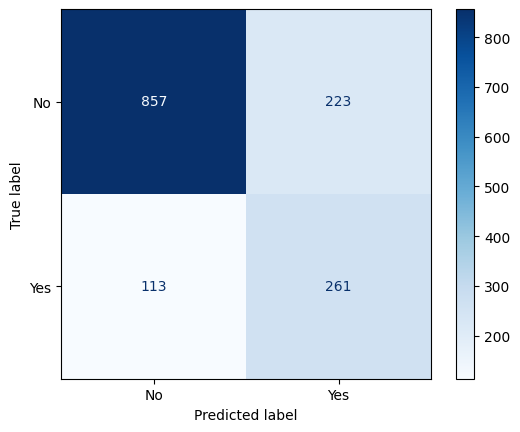

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train_bal)

# Predicciones
y_pred_logreg = log_reg.predict(X_test_scaled)

# Métricas
acc_lr = accuracy_score(y_test, y_pred_logreg)
prec_lr = precision_score(y_test, y_pred_logreg, pos_label="Yes")
recall_lr = recall_score(y_test, y_pred_logreg, pos_label="Yes")
f1_lr = f1_score(y_test, y_pred_logreg, pos_label="Yes")

print("📊 Regresión Logística")
print(f"Exactitud: {acc_lr:.4f}")
print(f"Precisión: {prec_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-score: {f1_lr:.4f}")

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_logreg, labels=["No", "Yes"])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No", "Yes"])
disp_lr.plot(cmap="Blues")


### Modelo 2 – Random Forest (no requiere normalización)


📊 Random Forest
Exactitud: 0.7902
Precisión: 0.6169
Recall: 0.4866
F1-score: 0.5441


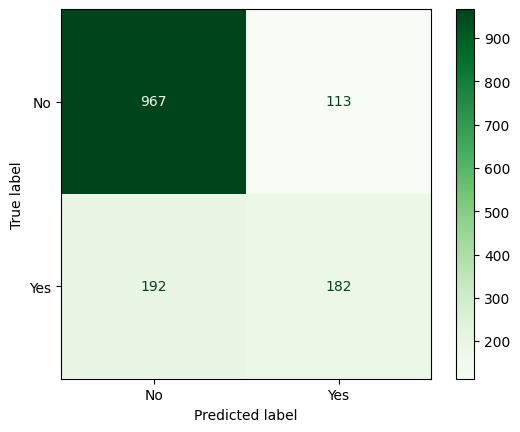

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entrenamiento
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_rf = rf.predict(X_test)

# Métricas
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, pos_label="Yes")
recall_rf = recall_score(y_test, y_pred_rf, pos_label="Yes")
f1_rf = f1_score(y_test, y_pred_rf, pos_label="Yes")

print("\n📊 Random Forest")
print(f"Exactitud: {acc_rf:.4f}")
print(f"Precisión: {prec_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["No", "Yes"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No", "Yes"])
disp_rf.plot(cmap="Greens")


## Evaluación de los Modelos

Evaluar cada modelo utilizando las siguientes métricas: Exactitud, Precisión, Recall, F1-score y Matriz de confusión.

 1️⃣ Métricas de desempeño

| Modelo               | Exactitud | Precisión | Recall  | F1-score |
|----------------------|-----------|-----------|---------|----------|
| Regresión Logística  | 0.7689    | 0.5393    | 0.6979  | 0.6084   |
| Random Forest        | 0.7902    | 0.6169    | 0.4866  | 0.5441   |

---

 2️⃣ Interpretación de métricas

- **Exactitud**: Random Forest tiene ligeramente mejor exactitud general (0.7902 > 0.7689).  
- **Precisión**: Random Forest predice churn con mayor confiabilidad (0.6169 > 0.5393).  
- **Recall**: Regresión Logística captura más clientes que realmente cancelaron (0.6979 > 0.4866), importante para estrategias de retención.  
- **F1-score**: Regresión Logística tiene mejor equilibrio entre precisión y recall (0.6084 > 0.5441).

---

 3️⃣ Análisis crítico

   🔹 Regresión Logística
- **Ventaja**: Mayor recall, detecta más churns reales.  
- **Desventaja**: Precisión moderada → algunos clientes predichos como churn realmente no cancelarán.  
- **Overfitting / Underfitting**: No parece presentar overfitting; es un modelo simple y estable.

🔹 Random Forest
- **Ventaja**: Mayor precisión y exactitud general.  
- **Desventaja**: Bajo recall → pierde clientes que sí cancelan.  
- **Overfitting / Underfitting**: Posible underfitting para la clase minoritaria (`Yes`). Ajustes recomendados:  
  - Usar `class_weight='balanced'`  
  - Aumentar `n_estimators` o `max_depth`  

---

 4️⃣ Conclusiones

- **Objetivo: detectar clientes que cancelan** → **Regresión Logística** es más adecuada (mayor recall y F1-score).  
- **Objetivo: minimizar falsos positivos** → **Random Forest** es mejor (mayor precisión y exactitud).  
- En la práctica, se puede:  
  - Ajustar Random Forest para mejorar recall (balance de clases, hiperparámetros).  
  - Combinar ambos modelos o usar ensemble para un mejor balance precisión-recall.

---

📌 **Recomendación final:**  
Para estrategias de retención de clientes, priorizar **recall** es crucial para no perder clientes que realmente podrían cancelar. Por eso, la Regresión Logística puede ser el punto de partida, con posibilidad de mejorar Random Forest ajustando parámetros.


## Análisis de la Importancia de las Variables

Después de elegir los modelos, realizar el análisis de las variables más relevantes para la predicción de la cancelación:

- Regresión Logística: Investigar los coeficientes de las variables, que muestran su contribución a la predicción de cancelación.

- Random Forest: Utilizar la importancia de las variables proporcionadas por el modelo. Random Forest calcula la importancia basándose en cómo cada variable contribuye a la reducción de la impureza durante las divisiones de los árboles.

### Modelo 1 – Regresión Logística – Coeficientes

En Regresión Logística, los coeficientes indican la fuerza y dirección de cada variable sobre la probabilidad de churn:

Coeficiente positivo → aumenta la probabilidad de churn (Yes).

Coeficiente negativo → disminuye la probabilidad de churn (Yes).

---
💡 Interpretación:

Variables con coeficientes altos en valor absoluto son las que más contribuyen a predecir churn. El signo dice si aumenta o disminuye la probabilidad de cancelación.

In [ ]:
import pandas as pd
import numpy as np

# Obtener coeficientes
coef = log_reg.coef_[0]
features = X_train_bal.columns
coef_df = pd.DataFrame({'Variable': features, 'Coeficiente': coef})

# Ordenar por importancia absoluta
coef_df['AbsCoef'] = np.abs(coef_df['Coeficiente'])
coef_df = coef_df.sort_values(by='AbsCoef', ascending=False)

# Mostrar las 10 variables más influyentes
print("🔹 Top 10 variables por coeficiente (Regresión Logística)")
print(coef_df.head(10))


🔹 Top 10 variables por coeficiente (Regresión Logística)
                                    Variable  Coeficiente   AbsCoef
1                            customer.tenure    -0.682390  0.682390
7290               account.Contract_Two year    -0.517766  0.517766
7275    internet.InternetService_Fiber optic     0.438136  0.438136
7293  account.PaymentMethod_Electronic check     0.429403  0.429403
7289               account.Contract_One year    -0.418813  0.418813
7278             internet.OnlineSecurity_Yes    -0.384482  0.384482
7284                internet.TechSupport_Yes    -0.383617  0.383617
7291            account.PaperlessBilling_Yes     0.289074  0.289074
7280               internet.OnlineBackup_Yes    -0.266576  0.266576
7270                    customer.Partner_Yes    -0.219160  0.219160


### Modelo 2 – Random Forest – Importancia de Variables

Random Forest proporciona importancia de cada variable basada en la reducción de impureza (Gini o Entropía) en los nodos de los árboles.


---
💡 Interpretación:

Las variables en la parte superior del gráfico son las que más ayudan a dividir los nodos y reducir la impureza. Esto indica qué factores son determinantes para predecir si un cliente cancelará.

🔹 Top 10 variables por importancia (Random Forest)
                                    Variable  Importancia
1                            customer.tenure     0.063413
2                    account.Charges.Monthly     0.042190
7293  account.PaymentMethod_Electronic check     0.037924
7284                internet.TechSupport_Yes     0.029420
7278             internet.OnlineSecurity_Yes     0.028916
7290               account.Contract_Two year     0.028102
7289               account.Contract_One year     0.025238
7270                    customer.Partner_Yes     0.025179
7275    internet.InternetService_Fiber optic     0.024677
7271                 customer.Dependents_Yes     0.023456


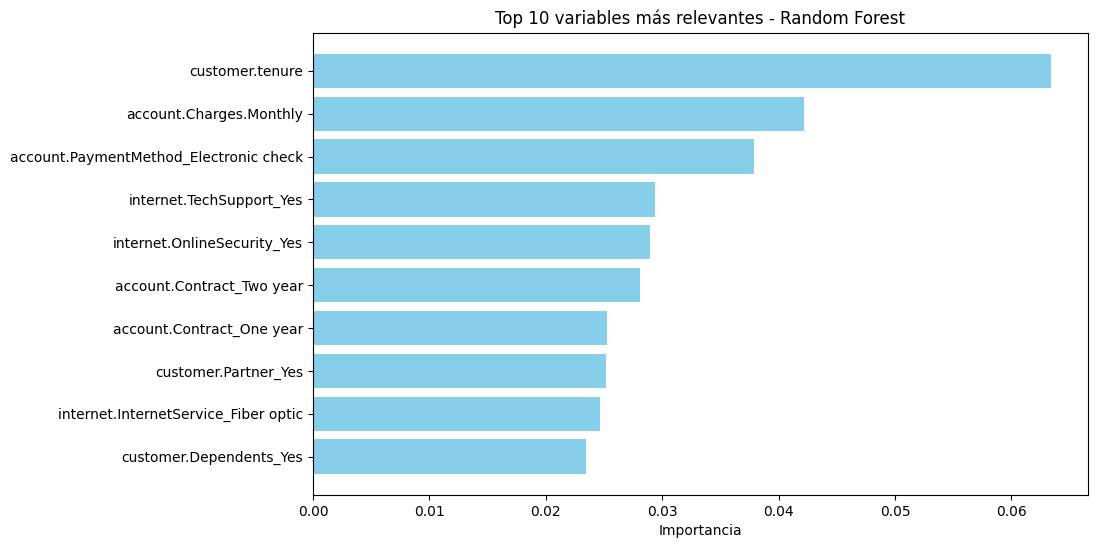

In [ ]:
import matplotlib.pyplot as plt

# Obtener importancia de variables
importances = rf.feature_importances_
features = X_train_bal.columns
rf_importance_df = pd.DataFrame({'Variable': features, 'Importancia': importances})

# Ordenar por importancia
rf_importance_df = rf_importance_df.sort_values(by='Importancia', ascending=False)

# Mostrar las 10 variables más importantes
print("🔹 Top 10 variables por importancia (Random Forest)")
print(rf_importance_df.head(10))

# Gráfico de barras
plt.figure(figsize=(10,6))
plt.barh(rf_importance_df['Variable'].head(10)[::-1], rf_importance_df['Importancia'].head(10)[::-1], color='skyblue')
plt.xlabel("Importancia")
plt.title("Top 10 variables más relevantes - Random Forest")
plt.show()


## 📄 Informe Final

### 1️⃣ Variables más relevantes por modelo

#### 🔹 Regresión Logística (Top 10 coeficientes)
| Variable                                   | Coeficiente | AbsCoef |
|--------------------------------------------|------------|---------|
| customer.tenure                             | -0.682390  | 0.682390|
| account.Contract_Two year                    | -0.517766  | 0.517766|
| internet.InternetService_Fiber optic        | 0.438136   | 0.438136|
| account.PaymentMethod_Electronic check      | 0.429403   | 0.429403|
| account.Contract_One year                    | -0.418813  | 0.418813|
| internet.OnlineSecurity_Yes                 | -0.384482  | 0.384482|
| internet.TechSupport_Yes                     | -0.383617 | 0.383617|
| account.PaperlessBilling_Yes                | 0.289074   | 0.289074|
| internet.OnlineBackup_Yes                   | -0.266576  | 0.266576|
| customer.Partner_Yes                        | -0.219160  | 0.219160|

Variables con coeficiente negativo reducen la probabilidad de churn.  
> - `customer.tenure` → clientes con más tiempo en la compañía tienen menor probabilidad de cancelar.  
> - `account.Contract_Two year` → contratos a largo plazo disminuyen churn.  

Variables con coeficiente positivo aumentan la probabilidad de churn.  
> - `internet.InternetService_Fiber optic` y `account.PaymentMethod_Electronic check` → clientes con este servicio o método de pago tienen mayor riesgo de cancelación.

---

#### 🔹 Random Forest (Top 10 importancia de variables)
| Variable                                   | Importancia |
|--------------------------------------------|------------|
| customer.tenure                             | 0.063413   |
| account.Charges.Monthly                      | 0.042190   |
| account.PaymentMethod_Electronic check      | 0.037924   |
| internet.TechSupport_Yes                     | 0.029420   |
| internet.OnlineSecurity_Yes                 | 0.028916   |
| account.Contract_Two year                    | 0.028102   |
| account.Contract_One year                    | 0.025238   |
| customer.Partner_Yes                        | 0.025179   |
| internet.InternetService_Fiber optic        | 0.024677   |
| customer.Dependents_Yes                     | 0.023456   |

>- `customer.tenure` es la variable más importante en ambos modelos → indica que la antigüedad del cliente es clave para la retención.  
> - `account.Charges.Monthly` también es relevante → clientes con cargos mensuales altos tienen mayor riesgo de churn.  
> - Servicios de soporte técnico y seguridad (`TechSupport`, `OnlineSecurity`) disminuyen la probabilidad de cancelar, evidenciando la importancia de un buen servicio.  
> - Métodos de pago como `Electronic check` aumentan riesgo de churn, probablemente por menor compromiso financiero.  
> - Contratos largos (One year / Two year) reducen churn.

---

### 2️⃣ Principales factores que afectan la cancelación

1. **Antigüedad del cliente**: Clientes nuevos tienen más riesgo de cancelar.  
2. **Tipo de contrato**: Contratos largos (1 o 2 años) reducen la probabilidad de churn.  
3. **Servicios contratados**:  
   - Clientes con soporte técnico o seguridad tienden a permanecer más tiempo.  
   - Servicios como `Fiber optic` se asocian a mayor cancelación, posiblemente por precios o expectativas de servicio.  
4. **Método de pago**: Pagos electrónicos se asocian a mayor churn → menor compromiso percibido.  
5. **Cargos mensuales**: Montos altos incrementan riesgo de cancelación.  
6. **Características personales**: Tener pareja (`Partner_Yes`) o dependientes reduce ligeramente el riesgo de churn.

---

### 3️⃣ Estrategias de retención basadas en resultados

1. **Incentivos para clientes nuevos**: Ofrecer descuentos iniciales o paquetes de bienvenida para los clientes con menor `tenure`.  

2. **Contratos a largo plazo**: Incentivar a los clientes a optar por contratos de 1 o 2 años con beneficios adicionales.  

3. **Mejorar servicios clave**: Reforzar soporte técnico y servicios de seguridad online. Además, comunicar claramente beneficios de servicios como `Fiber optic` para reducir cancelaciones.  

4. **Optimización de métodos de pago**: Ofrecer alternativas de pago más comprometidas, o incentivos para métodos más estables que reduzcan riesgo de churn.  

5. **Gestión de clientes con cargos altos**: Analizar planes de precios y ofrecer beneficios o programas de fidelidad a clientes con facturas mensuales altas.

---

### 4️⃣ Conclusión general

- La **antigüedad del cliente**, el **tipo de contrato**, los **servicios contratados**, los **métodos de pago** y los **cargos mensuales** son los factores más determinantes para predecir cancelación.  
- Estrategias de retención deben enfocarse en **clientes nuevos**, **contratos a largo plazo**, y en **mejorar la experiencia con servicios y pagos**.  
- Ambos modelos son consistentes en identificar los mismos factores clave, aunque Random Forest ofrece una visión más global de la importancia relativa de cada variable, mientras que Regresión Logística muestra la **dirección del efecto** (positivo o negativo) sobre el churn.